<a href="https://colab.research.google.com/github/HosseinEyvazi/Voice-AI-Booklet/blob/main/Voice_Sec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This guide covers the fundamental concepts of audio processing required for sentiment analysis, followed by a practical code example for the SAVEE dataset.

### Part 1: Fundamentals of Sound Waves

Sound travels as a pressure wave through a medium (like air). We can represent this wave graphically, where the properties of the graph tell us about the sound we hear.

#### Key Properties of Sound Waves

1.  **Amplitude (Loudness/Intensity):**

      * **Definition:** Amplitude is the maximum displacement or height of the wave from its equilibrium position (the center line).
      * **Perception:** It corresponds directly to the sound's **loudness** or **volume**. A higher amplitude means more pressure variation and a louder sound.
      * **Y-axis interpretation:** The y-axis represents the change in air pressure caused by the sound wave at a specific point in time.

2.  **Frequency (Pitch):**

      * **Definition:** Frequency is the number of complete cycles (or peaks) of the wave that occur in one second. It is measured in Hertz (Hz).
      * **Perception:** It corresponds directly to the **pitch** of the sound. Low frequency = deep bass sound; high frequency = high-pitched, shrill sound.
      * **Human Hearing Range:** Humans can typically hear frequencies between **20 Hz and 20,000 Hz (20 kHz)**.

3.  **Wavelength ($\\lambda$) and Period ($T$):**

      * **Period ($T$):** The time it takes to complete one full cycle of the wave. It has an inverse relationship with frequency: $T = 1/f$.
      * **Wavelength ($\\lambda$):** The physical distance a wave travels during one cycle. It also has an inverse relationship with frequency (higher frequency waves are shorter).

4.  **Energy:**

      * A sound wave's energy has a direct relationship with its frequency and amplitude. Higher frequency waves carry more energy, and higher amplitude waves carry more energy.

-----

### Part 2: Digital Audio Concepts

Computers cannot store continuous analog waves. They must convert them into a digital format through sampling.

#### 1\. Analog vs. Digital Signals

  * **Analog Signal:** A continuous signal where the varying feature (like voltage or pressure) represents the sound wave exactly as it changes over time. It's smooth and infinitely detailed.
  * **Digital Signal:** A discrete representation of the analog signal. We take measurements (samples) at regular intervals. The computer stores these individual measurements as numbers.

[Image comparing a smooth analog wave to a stepped digital wave representation]

#### 2\. Sample Rate

  * **Definition:** The number of samples (measurements) taken per second from the analog signal to create the digital signal. Measured in Hz or kHz.
  * **Significance:** A higher sample rate results in a higher fidelity (more accurate) representation of the original sound, capturing more detail, especially at high frequencies.
      * *Example:* A sample rate of 16,000 Hz (16 kHz) means the computer stores 16,000 numbers for every second of audio. This is common for speech recognition. CD quality audio uses 44,100 Hz (44.1 kHz).

#### 3\. Channels

  * **Mono:** One channel of audio. All sound information is combined into a single stream.
  * **Stereo:** Two channels (left and right). This allows for spatial separation, making the sound feel more immersive. Multi-channel audio (e.g., surround sound) uses even more channels.

-----

### Part 3: Feature Engineering with Fourier Transform

For a machine learning model, the raw waveform (a sequence of amplitude numbers) is not very informative. We need to extract meaningful features that describe the content. The most crucial tool for this is the **Fourier Transform**.

#### The Core Idea of Fourier Transform (FT)

The Fourier Transform is a mathematical tool that decomposes a complex signal from the **time domain** (amplitude over time) into the **frequency domain** (amplitude per frequency).

  * **Analogy:** Imagine a complex musical chord played on a piano. To your ear, it's one sound. The Fourier Transform "listens" to that chord and tells you exactly which individual notes (e.g., C, E, and G) were pressed to create it.
  * **Feature Extraction:** The complex input wave is broken down into numerous simple sine waves. Each sine wave component acts as a **feature**. For example, one component might represent background noise (like an air conditioner hum), while others represent different parts of human speech (vowels, consonants). The sum of all these simple waves reconstructs the original complex wave.

#### Application: Spectrograms and Denoising

  * **Spectrogram:** When we apply the Fourier Transform repeatedly over short, overlapping windows of an audio file, we create a **spectrogram**. This image plots time on the x-axis, frequency on the y-axis, and uses color intensity for the amplitude of each frequency. This is a powerful visualization and feature for AI models.
  * **Denoising:** If we identify that a specific frequency range in the spectrogram corresponds to unwanted noise, we can simply set the amplitude of that frequency range to zero and then reconstruct the signal. The resulting wave will be denoised.

-----

### Part 4: Audio Feature Engineering with Librosa

The **Librosa** library in Python is the industry standard for audio feature extraction. It generates features that are highly effective for machine learning.

1.  **Mel Spectrogram:**

      * This is the most common feature for audio classification. It's an improvement on the standard spectrogram.
      * The frequency axis is converted to the **Mel scale**, which mimics how humans perceive pitch. Humans are better at distinguishing small changes in low frequencies than high frequencies. The Mel scale emphasizes the lower frequencies where most human speech information resides, making it more effective for tasks like sentiment analysis.

2.  **MFCC (Mel-Frequency Cepstral Coefficients):**

      * MFCCs take the Mel spectrogram and further compress it by applying a discrete cosine transform (DCT). This process captures the essential characteristics of the vocal tract shape and filters out background noise and less important variations. MFCCs are highly compact and efficient features.

3.  **Other Features:**

      * **Chroma Features:** Represent the harmonic content of music, useful for identifying chords and keys.
      * **Zero-Crossing Rate:** Measures how many times the signal crosses the zero axis. High rates often indicate noise or unvoiced sounds (like 's' or 'f').

-----

### Part 5: Code Example - Sentiment Analysis on SAVEE Dataset

This example demonstrates the workflow for classifying emotions from audio files using Librosa features and a simple machine learning model.

The SAVEE dataset typically labels files with codes indicating the emotion (e.g., 'a' for anger, 'sa' for sadness).

```python
# necessary libraries
# !pip install librosa numpy scikit-learn soundfile

import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron Classifier
from sklearn.metrics import classification_report

# --- Configuration ---

# Path to your SAVEE dataset directory where audio files are located
DATASET_PATH = "path/to/your/SAVEE/AudioData"

# Define the emotion mapping based on SAVEE file naming conventions
# Example file: 'a01.wav' -> 'a' = anger
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# --- 1. Feature Extraction Function ---
def extract_features(file_path):
    """Loads audio file and extracts Mel spectrogram features."""
    try:
        # Load audio file. sr=None preserves the original sample rate.
        # y = audio time series, sr = sample rate
        y, sr = librosa.load(file_path, sr=None)

        # 1. Extract Mel Spectrogram features
        # n_mels specifies the number of Mel bands (features) to generate.
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

        # 2. Aggregate features over time by taking the mean across the time axis
        # This creates a single feature vector for the entire audio clip.
        aggregated_features = np.mean(mel_spectrogram.T, axis=0)

        return aggregated_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- 2. Load Data and Process Files ---
def load_data(dataset_path):
    features = []
    labels = []

    for file_name in os.listdir(dataset_path):
        if file_name.endswith('.wav'):
            # Parse emotion label from filename (e.g., 'sa' from 'sa01.wav')
            label_code = file_name.split('_')[0][:-2] # Adjust parsing based on exact filename format

            # Handle potential parsing errors or different file structures safely
            if label_code in emotion_map:
                emotion = emotion_map[label_code]
                file_full_path = os.path.join(dataset_path, file_name)

                # Extract features from the audio file
                data_features = extract_features(file_full_path)

                if data_features is not None:
                    features.append(data_features)
                    labels.append(emotion)

    return np.array(features), np.array(labels)

print("Loading data and extracting features...")
X, y = load_data(DATASET_PATH)
print(f"Loaded {len(X)} samples.")

# --- 3. Prepare Data for Machine Learning ---

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features: standardizing data (mean=0, variance=1) improves model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. Train the Model ---
print("Training Neural Network Classifier...")
# Using a simple Multi-layer Perceptron (MLP) a type of neural network.
model = MLPClassifier(hidden_layer_sizes=(256, 128), # Two hidden layers
                      activation='relu',
                      solver='adam',
                      max_iter=500,
                      random_state=42,
                      early_stopping=True)

model.fit(X_train_scaled, y_train)

# --- 5. Evaluate the Model ---
print("\nModel Evaluation:")
predictions = model.predict(X_test_scaled)
print(classification_report(y_test, predictions, target_names=emotion_map.values()))
```

-----


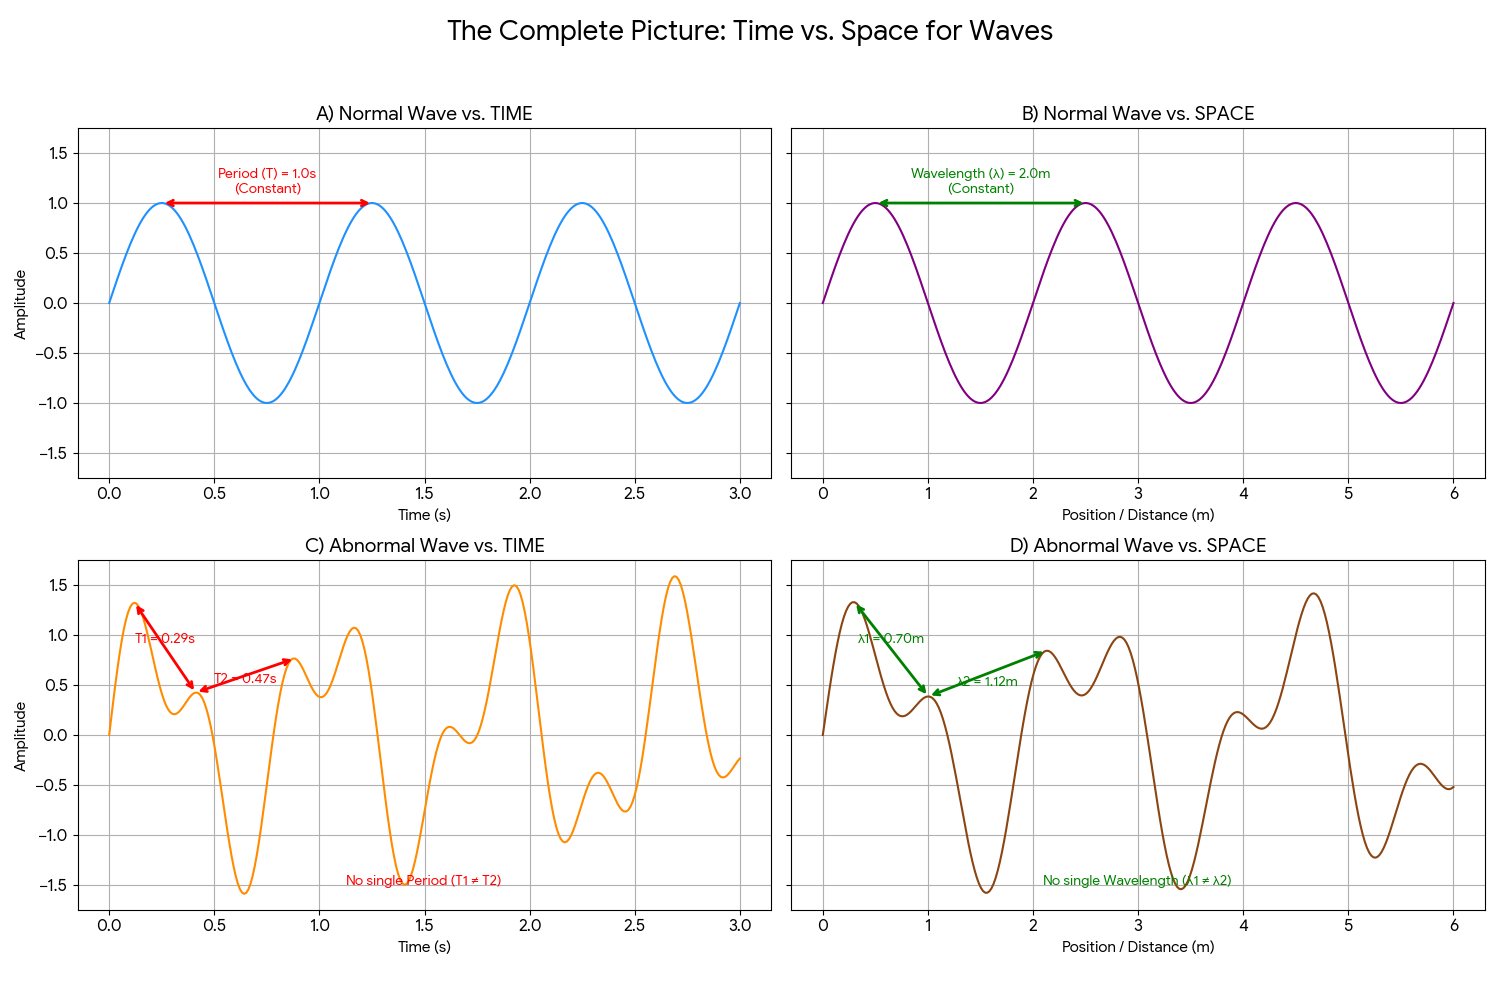
\
Note: x coordinates are different unlike y coordinates.

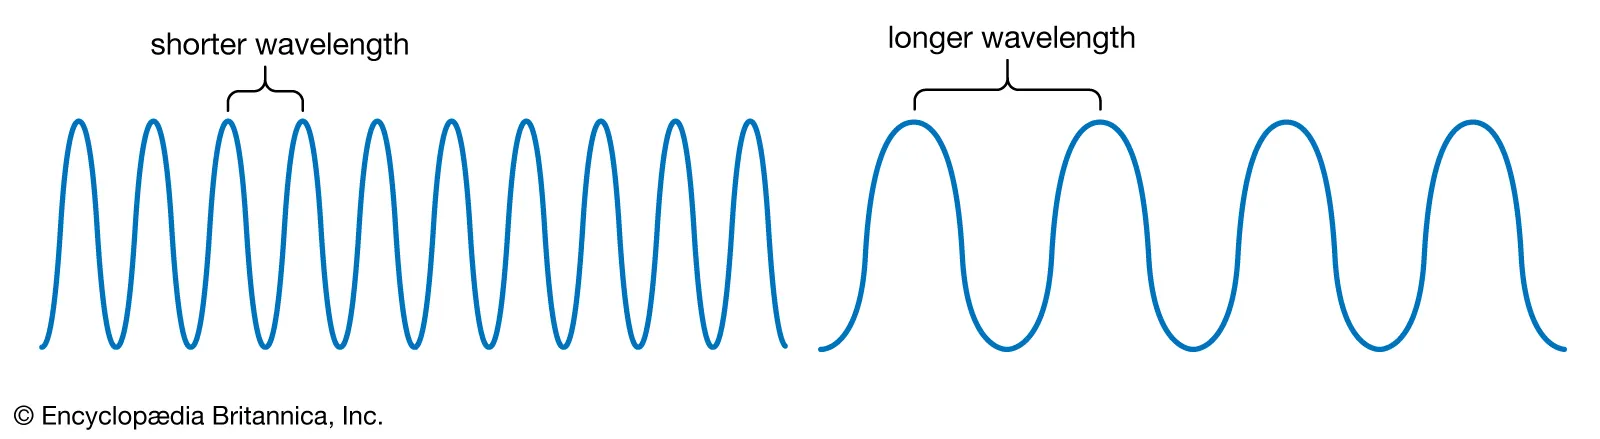

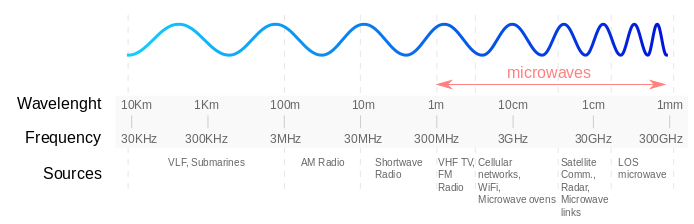

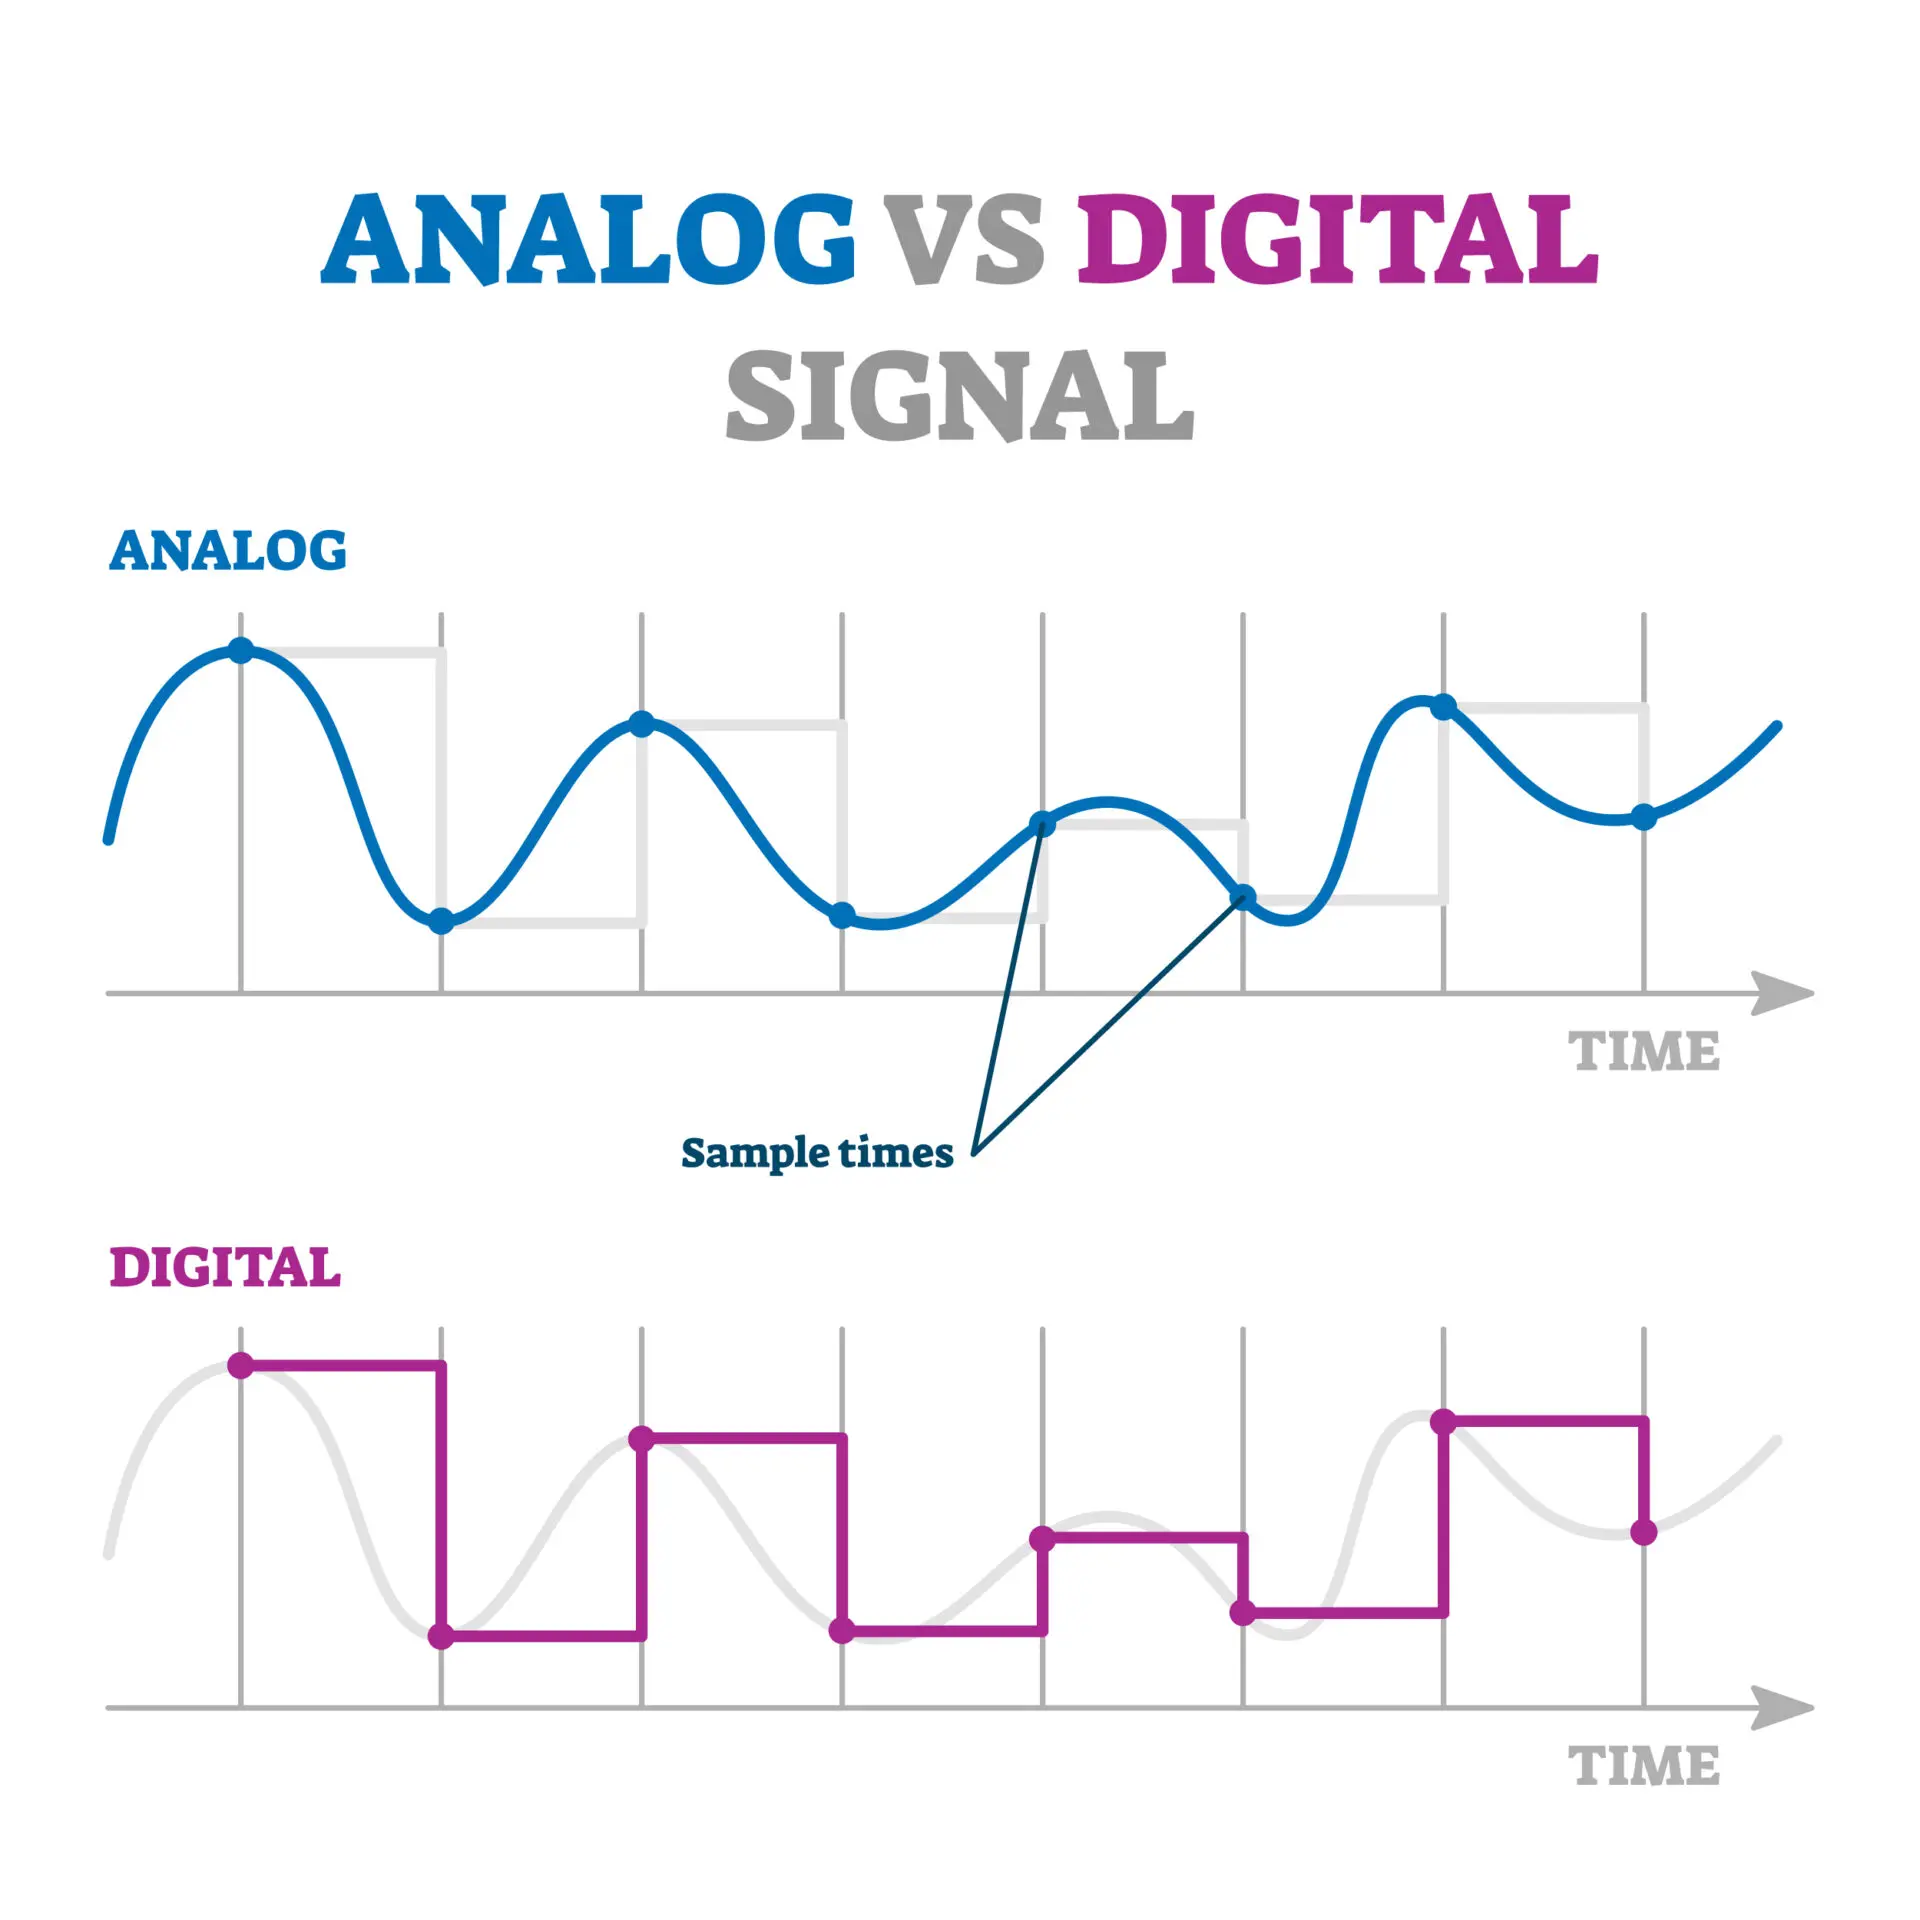

Feurier Transform

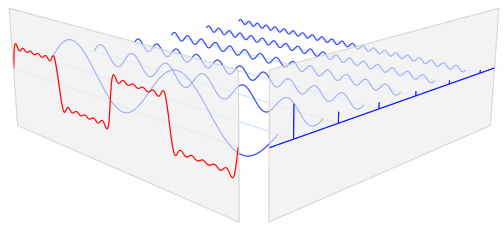

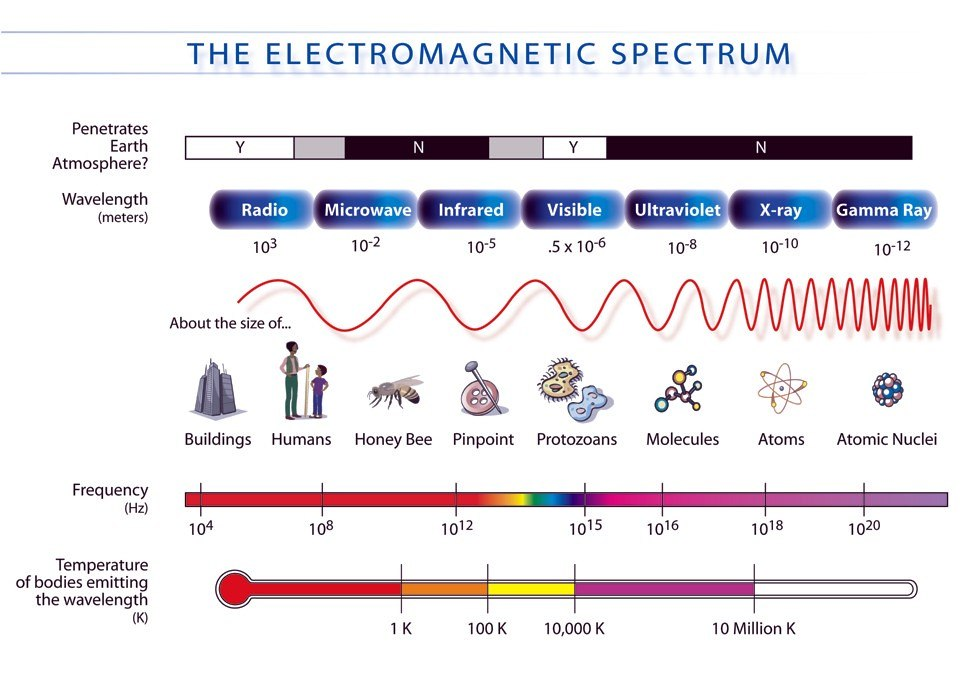

In [ ]:
#################################################################
#
#   A Booklet-Style Guide to Audio Analysis with Python's `wave`
#
#   This script is a hands-on lesson demonstrating the fundamental
#   properties of digital audio, such as frames and framerate.
#
#################################################################

import wave
import urllib.request
import os
# Import the Audio and display functions from IPython to play the sound
from IPython.display import Audio, display

# --- Part 1: Setting Up Our Experiment ---
# To learn about audio, we first need an audio file. This section
# downloads a standard .wav file that we will use for our analysis.

print("--- Part 1: Downloading Sample Audio ---")
# The previous URL was no longer working (HTTP 404 Error).
# I have replaced it with a new, stable URL from Wikimedia Commons.
audio_url = "https://file-examples.com/storage/fe3d9c3a9e68bb6379572f9/2017/11/file_example_WAV_1MG.wav"
original_filename = "original_audio.wav"

# Let's determine the full path where the file will be saved.
# This helps in debugging if the file is not found later.
working_directory = os.getcwd()
full_path = os.path.join(working_directory, original_filename)
print(f"Attempting to download and save file to: {full_path}")


try:
    urllib.request.urlretrieve(audio_url, original_filename)
    print(f"Download command executed for '{original_filename}'.")
except Exception as e:
    print(f"\n--- DOWNLOAD ERROR ---")
    print(f"An error occurred during the download attempt: {e}")
    print("This could be due to a network issue, a firewall, or the URL being temporarily unavailable.")
    exit() # Exit if download fails

print("-" * 40)

# --- Sanity Check: A more robust check to ensure the file was downloaded correctly ---
file_exists = os.path.exists(original_filename)
file_has_content = False
if file_exists:
    # Check if the file is not empty by making sure its size is greater than 0 bytes.
    file_has_content = os.path.getsize(original_filename) > 0

if not file_exists or not file_has_content:
    print(f"\n--- CRITICAL FILE ERROR ---")
    print(f"The script could not find or verify the audio file at: {full_path}")
    if not file_exists:
        print("Reason: The file does not exist. The download likely failed.")
    else:
        print("Reason: The file exists but is empty (0 bytes). The download was incomplete.")
    print("\nPossible Causes:")
    print("  1. Internet Connection: Your environment may not have access to the internet to download the file.")
    print("  2. Permissions: The script might not have permission to write files in the current directory.")
    print("  3. Firewall: A firewall might be blocking the connection to the download URL.")
    print("\nPlease check these possibilities and run the script again.")
    exit()

print("File check passed. Audio file is present and not empty.")
print("-" * 40)


# --- Part 2: Analyzing the Anatomy of a WAV File ---
# Now that we have our file, let's use the `wave` library to look
# inside and understand its properties.

print("\n--- Part 2: Analyzing the Original File ---")

with wave.open(original_filename, 'rb') as wav_file:
    # `getparams()` gives us all the metadata in one tuple.
    params = wav_file.getparams()
    print(f"All Parameters: {params}")

    # Let's break down the most important parameters:
    n_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth() # How many bytes for each sample
    framerate = wav_file.getframerate()    # The "playback speed" in Hz
    n_frames = wav_file.getnframes()       # The total number of audio snapshots

    # The duration of the audio is a simple calculation based on
    # the number of frames and the framerate.
    duration = n_frames / float(framerate)

    print(f"\nBreakdown:")
    print(f"  - Number of Channels: {n_channels}")
    print(f"  - Sample Width: {sample_width} bytes")
    print(f"  - Frame Rate (Sample Rate): {framerate} Hz (frames per second)")
    print(f"  - Total Number of Frames: {n_frames}")
    print(f"  - Calculated Duration: {duration:.2f} seconds")

print("-" * 40)

# --- Part 3: The Core Concept - Frames vs. Framerate ---
#
# A common question is: "If I have X frames and a framerate of Y,
# what happens if I change the framerate to Y/2? Does the file compress?"
#
# Let's analyze this:
# The formula for audio duration is: Duration = Total Frames / Framerate
#
#   - Original Duration = n_frames / framerate
#
# If we keep the number of frames the same but halve the framerate:
#
#   - New Duration = n_frames / (framerate / 2)
#   - New Duration = 2 * (n_frames / framerate)
#
# Conclusion: The audio duration will DOUBLE.
#
# This does not compress the file. Instead, it stretches it, playing
# each frame for twice as long. This creates a slow-motion, low-pitch effect.
#
#
# Let's prove this with code in the next step.
#
print("\n--- Part 3: Understanding the Theory (see comments in code) ---")
print("Theory: Halving the framerate will double the audio's duration.")
print("-" * 40)


# --- Part 4: The Experiment - Creating a Slowed-Down Version ---
# Here, we will create a new audio file. We'll copy all the frames
# from the original, but we'll set the framerate to half its value.

print("\n--- Part 4: Creating a New File with Half the Framerate ---")
slowed_filename = "slowed_audio.wav"

with wave.open(original_filename, 'rb') as original_wav:
    # Read all the audio frames and parameters from the original file
    frames = original_wav.readframes(n_frames)
    original_params = original_wav.getparams()

    with wave.open(slowed_filename, 'wb') as slowed_wav:
        # Configure the new file using the original's parameters...
        slowed_wav.setparams(original_params)
        # ...but overwrite the framerate with our new, slower value.
        slowed_wav.setframerate(int(framerate / 2))

        # Write the same audio frames into this new file configuration.
        slowed_wav.writeframes(frames)

print(f"Created '{slowed_filename}' with a framerate of {int(framerate/2)} Hz")
print("-" * 40)


# --- Part 5: Verifying the Results ---
# Let's analyze our new file and confirm our hypothesis from Part 3.

print("\n--- Part 5: Analyzing the Slowed File ---")
with wave.open(slowed_filename, 'rb') as wav_file:
    slow_n_frames = wav_file.getnframes()
    slow_framerate = wav_file.getframerate()
    slow_duration = slow_n_frames / float(slow_framerate)

    print(f"  - Number of Frames: {slow_n_frames} (Unchanged, as expected)")
    print(f"  - New Frame Rate: {slow_framerate} Hz (Successfully halved)")
    print(f"  - New Calculated Duration: {slow_duration:.2f} seconds (Successfully doubled!)")
print("-" * 40)


# --- Part 6: Listening to the Results ---
# The best way to understand the difference is to hear it.
# The following code will create audio players directly in your
# Jupyter Notebook output.

print("\n--- Part 6: Listening to the Results ---")

print("\n1. Original Audio:")
display(Audio(original_filename))

print("\n2. Slowed-Down Audio (Half Framerate):")
display(Audio(slowed_filename))


# --- Conclusion & Next Steps ---
print("\n--- Conclusion ---")
print("\nAs you can hear, the second audio file is twice as long and sounds much deeper.")
print("This proves our theory: the number of frames determines the audio content,")
print("while the framerate determines the speed and pitch of playback.")



--- Part 1: Downloading Sample Audio ---
Attempting to download and save file to: /content/original_audio.wav
Download command executed for 'original_audio.wav'.
----------------------------------------
File check passed. Audio file is present and not empty.
----------------------------------------

--- Part 2: Analyzing the Original File ---
All Parameters: _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=262094, comptype='NONE', compname='not compressed')

Breakdown:
  - Number of Channels: 2
  - Sample Width: 2 bytes
  - Frame Rate (Sample Rate): 44100 Hz (frames per second)
  - Total Number of Frames: 262094
  - Calculated Duration: 5.94 seconds
----------------------------------------

--- Part 3: Understanding the Theory (see comments in code) ---
Theory: Halving the framerate will double the audio's duration.
----------------------------------------

--- Part 4: Creating a New File with Half the Framerate ---
Created 'slowed_audio.wav' with a framerate of 22050 Hz


2. Slowed-Down Audio (Half Framerate):



--- Conclusion ---

As you can hear, the second audio file is twice as long and sounds much deeper.
This proves our theory: the number of frames determines the audio content,
while the framerate determines the speed and pitch of playback.


High and low samplerate

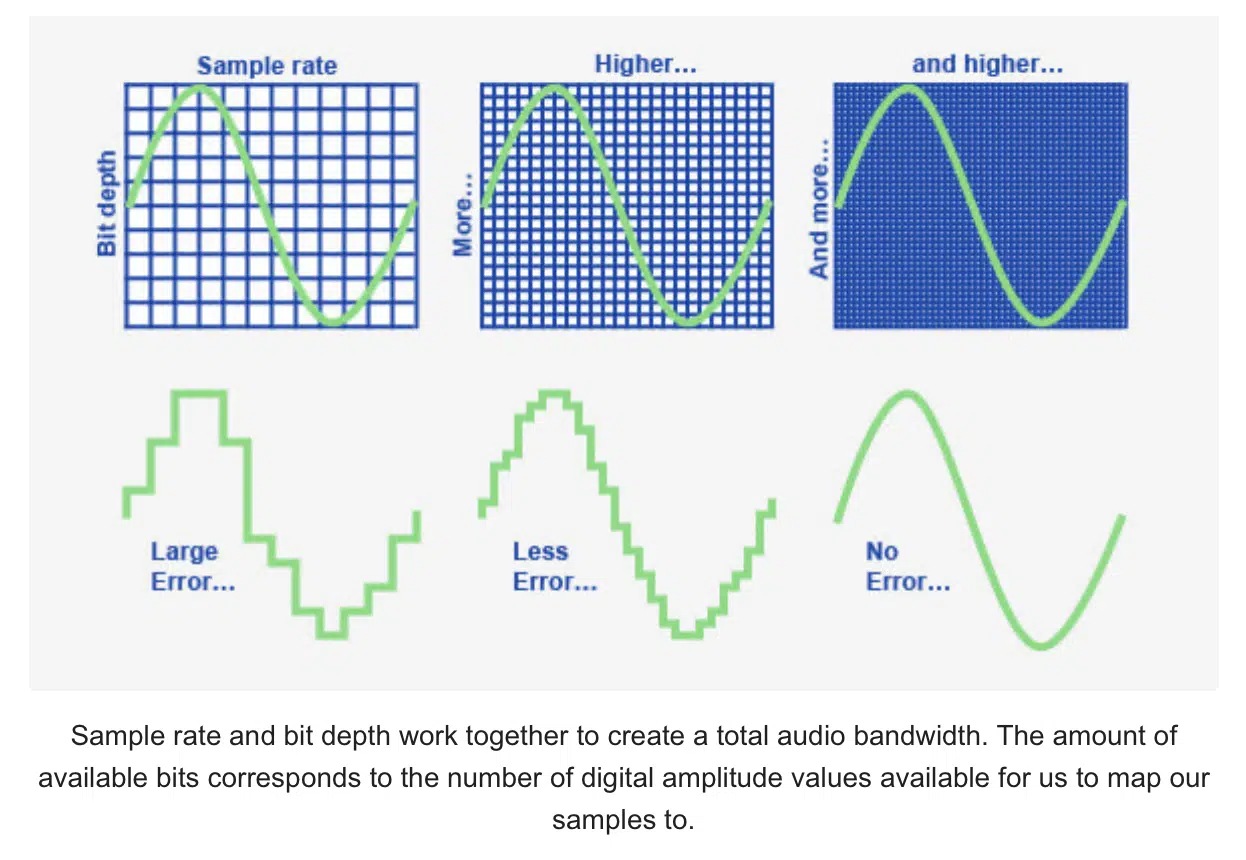


## A Booklet on Audio Processing with Librosa

This guide will walk you through the fundamental steps of analyzing and visualizing an audio file using the `librosa` library in Python.

### 1\. Loading Audio & Basic Properties

First, we load an audio file. `librosa` can handle local files or URLs. We'll load the audio into a NumPy array `y` and get its `sr` or **sample rate**. The sample rate is the number of data points (samples) the computer captures per second to represent the audio.

  * `y`: The audio time series (a NumPy array of amplitude values).
  * `sr`: The sample rate of the audio.

We can easily prove that the duration of the audio in seconds is the total number of samples divided by the sample rate.


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Load an example audio file from librosa's servers
audio_path = librosa.example('trumpet')
y, sr = librosa.load(audio_path)

# Get audio properties
num_samples = len(y)
duration = librosa.get_duration(y=y, sr=sr)

print(f"Sample Rate (sr): {sr} Hz")
print(f"Total Samples: {num_samples}")
print("-" * 20)
print(f"Calculated Duration: {num_samples / sr:.2f} seconds")
print(f"Librosa's Duration: {duration:.2f} seconds")

# You can listen to the audio directly
ipd.Audio(y, rate=sr)


Sample Rate (sr): 22050 Hz
Total Samples: 117601
--------------------
Calculated Duration: 5.33 seconds
Librosa's Duration: 5.33 seconds


### 2\. The Waveform: Visualizing Amplitude

The most basic plot is the **waveform**, which shows the change in **amplitude** (loudness/intensity) over **time**. Let's look at the raw amplitude values for a small slice of the audio and then plot the entire waveform.



Amplitude values for a small slice:
[ 0.1999282   0.2603135   0.25495908  0.14220762 -0.05279972 -0.25609937
 -0.39393613 -0.4314096  -0.3722541  -0.2535488 ]


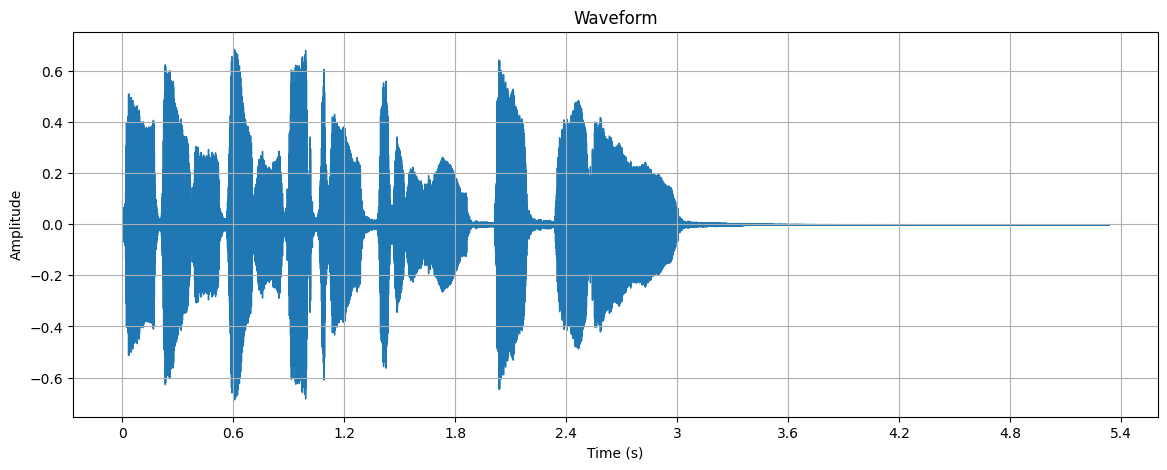

In [ ]:
# Look at the raw amplitude values for 10 samples
print("Amplitude values for a small slice:")
print(y[20000:20010])

# Plot the full waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



### 3\. Trimming Silence & The `top_db` Parameter

Often, audio files have silence at the beginning and end. We can trim this using `librosa.effects.trim`. This function considers anything quieter than `top_db` decibels below the loudest part of the audio to be silence.

  * A smaller `top_db` (e.g., 20) is more aggressive and will trim more.
  * A larger `top_db` (e.g., 60) is more conservative and will only trim true silence.

Let's trim the audio with two different `top_db` values and plot the results.


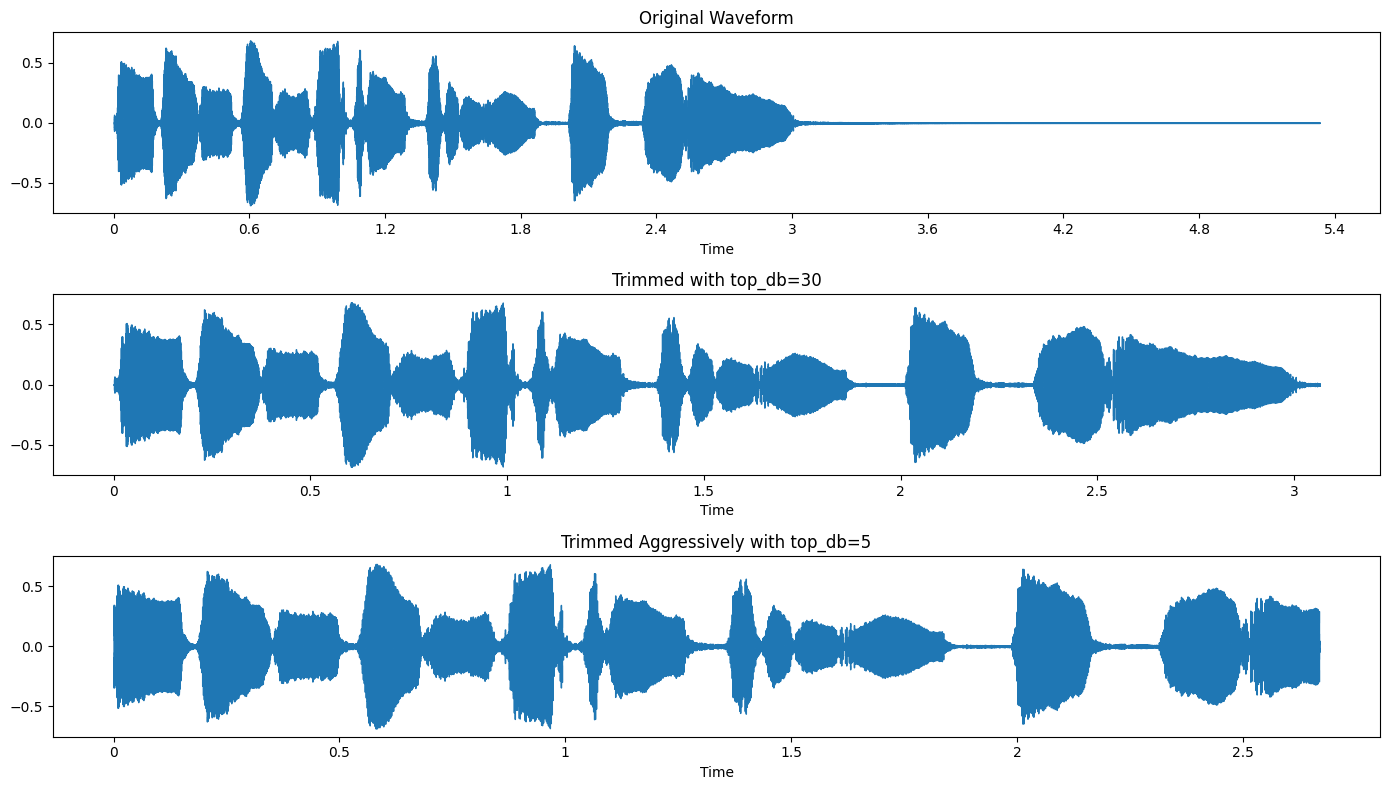

In [ ]:

# Trim with a standard top_db
y_trimmed_30, _ = librosa.effects.trim(y, top_db=30)

# Trim more aggressively
y_trimmed_5, _ = librosa.effects.trim(y, top_db=5)

# Plotting the comparisons
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Original Waveform')

plt.subplot(3, 1, 2)
librosa.display.waveshow(y_trimmed_30, sr=sr)
plt.title('Trimmed with top_db=30')

plt.subplot(3, 1, 3)
librosa.display.waveshow(y_trimmed_5, sr=sr)
plt.title('Trimmed Aggressively with top_db=5')

plt.tight_layout()
plt.show()



### 4\. Zooming In on the Wave

To see the actual shape of the sound wave, we need to zoom in on a very small time slice. Below, we plot just a fraction of a second. In this view, we can see the individual oscillations. The time it takes to complete one full cycle is the **period**, which is the time-domain equivalent of **wavelength**.


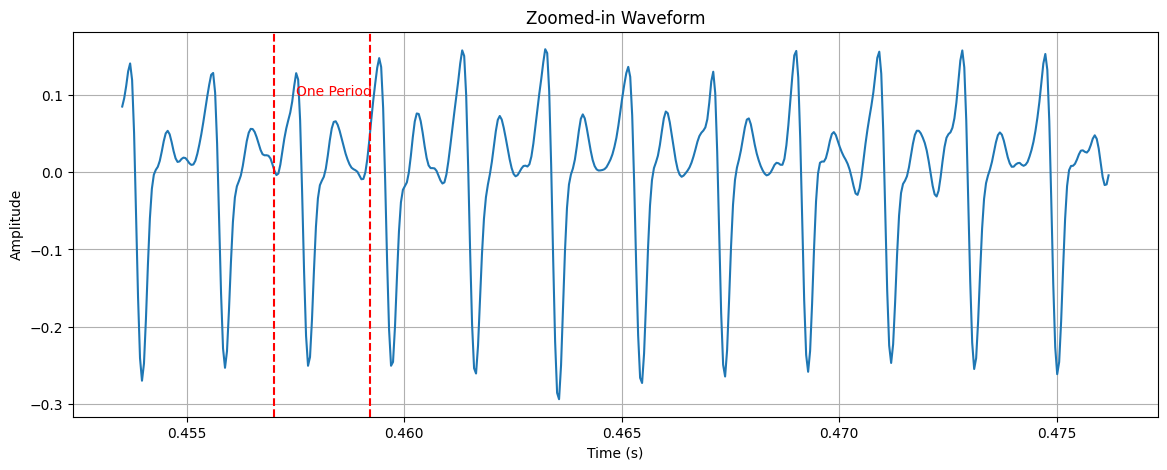

In [ ]:

# Zoom in on a small section of the trimmed audio
start_sample = 10000
end_sample = 10500
zoom_slice = y_trimmed_30[start_sample:end_sample]

# Create a time axis for the slice
t = np.linspace(start_sample/sr, end_sample/sr, num=len(zoom_slice))

plt.figure(figsize=(14, 5))
plt.plot(t, zoom_slice)
plt.title('Zoomed-in Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Highlight one approximate period (wavelength in time)
plt.axvline(x=0.457, color='r', linestyle='--')
plt.axvline(x=0.4592, color='r', linestyle='--')
plt.text(0.4575, 0.1, 'One Period', color = 'red')

plt.grid(True)
plt.show()



### 5\. Spectrograms: The Picture of Sound

#### The Fourier Transform & Decibels

To get from the time domain (waveform) to the frequency domain, we use the **Fourier Transform**. This mathematical tool breaks down the wave into its "ingredients": the various frequencies that make it up. The result of a Fourier Transform is a set of **complex numbers**, which have both a real part (magnitude) and an imaginary part (phase).

We then convert the magnitude of these frequencies into **Decibels (dB)**. A decibel is a **logarithmic unit**, which helps us represent the huge range of sound intensities in a way that matches human hearing.

#### Plotting the Spectrogram

A **spectrogram** is a visual representation of this frequency information over time. It's a 3D plot:

  * **X-axis:** Time
  * **Y-axis:** Frequency
  * **Color:** Amplitude (in Decibels)

Spectrograms turn sound into images. This is incredibly powerful because it means we can use image-based AI models, like **Convolutional Neural Networks (CNNs)**, to classify and understand audio\!


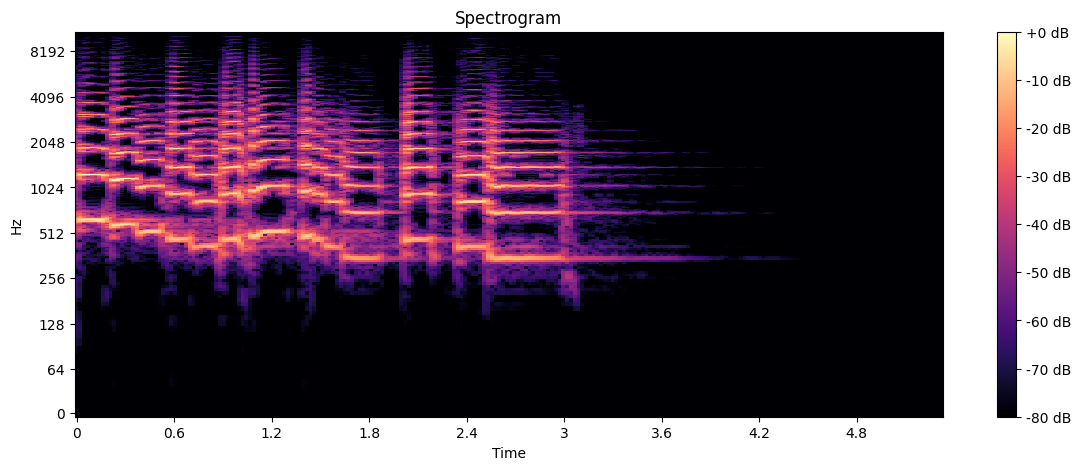

In [ ]:

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)
# Convert to decibels
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()



### 6\. Plots and Energy: A Quick Review

  * **Waveform (2D):** Shows `Time + Amplitude`.
  * **Spectrum (2D):** Shows `Frequency + Amplitude` for the whole clip at once.
  * **Spectrogram (3D):** Shows `Time + Frequency + Amplitude (as color)`.

**Which plot shows energy?** All of them do, since energy is proportional to amplitude. However, the **spectrogram** gives the most complete energy map across both time and frequency.

**Is energy related to amplitude, frequency, or both?**
For mechanical waves like sound, the energy is proportional to **amplitude squared**. However, a higher **frequency** delivers more energy per second (more power). For a single particle of light (a photon), its energy is related only to its frequency.

### 7\. Mel Spectrogram: Hearing Like a Human

A **Mel Spectrogram** is a special kind of spectrogram where the frequency axis is converted to the **Mel scale**. The Mel scale is a perceptual scale that mimics human hearing.

**Why is this good for human-like tasks?**
Humans are much better at distinguishing between lower frequencies than higher ones (e.g., the difference between 100 Hz and 200 Hz is obvious, but 8100 Hz vs. 8200 Hz is not). The Mel spectrogram emphasizes these important low- and mid-range frequencies, which is where the fundamental frequencies of speech and most music are located. This makes it a far more useful input for AI models trying to understand voice or music.

Mathematically, it works by:

1.  Using a logarithmic formula (the **Mel Scale**) to create a set of filters.
2.  Multiplying a standard spectrogram by these filters to group high frequencies and keep low frequencies detailed.
3.  Taking the logarithm of the result to measure the energy in decibels (dB).

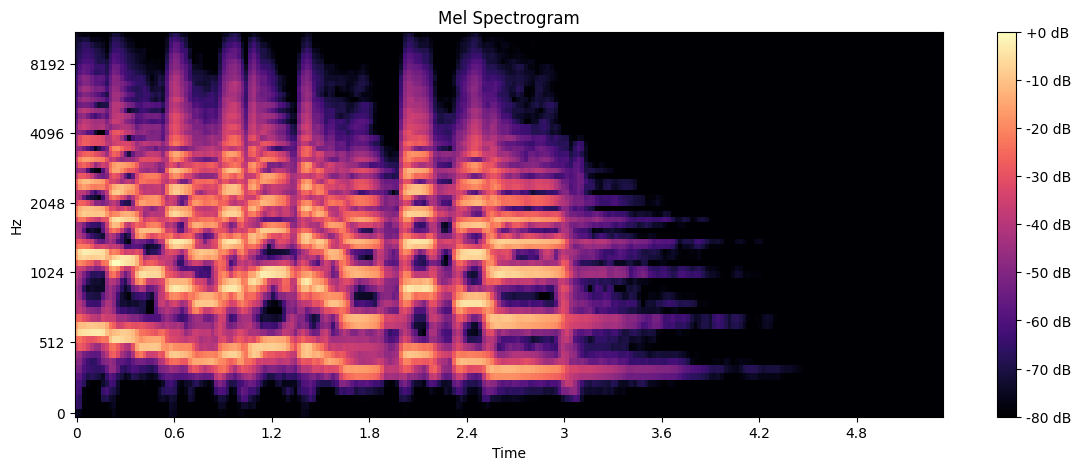

In [ ]:
# Compute a Mel-scaled spectrogram
S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


Note that higher number of mels makes image resultion higher.

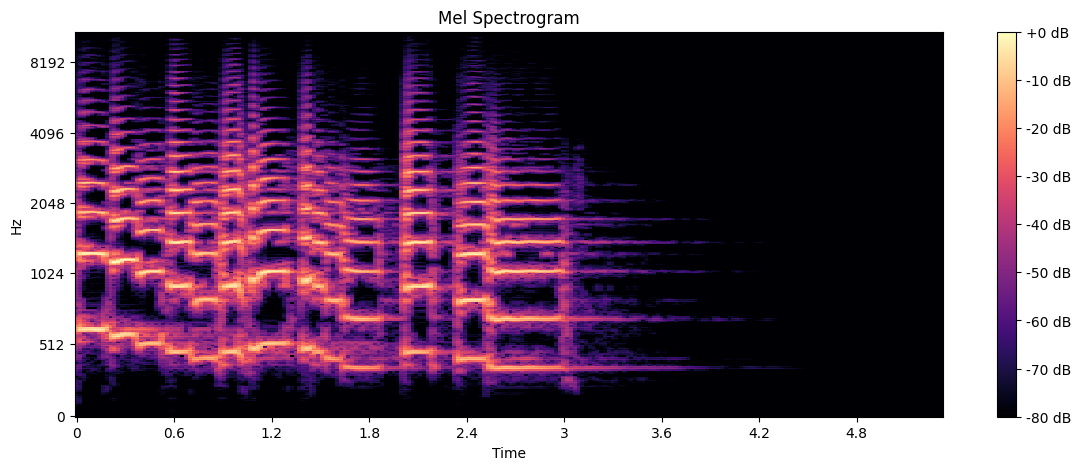

In [ ]:
# Compute a Mel-scaled spectrogram
S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=512)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


### Feureir Transformer can also convert waveforms to Spectrums (in addition to decomposition)

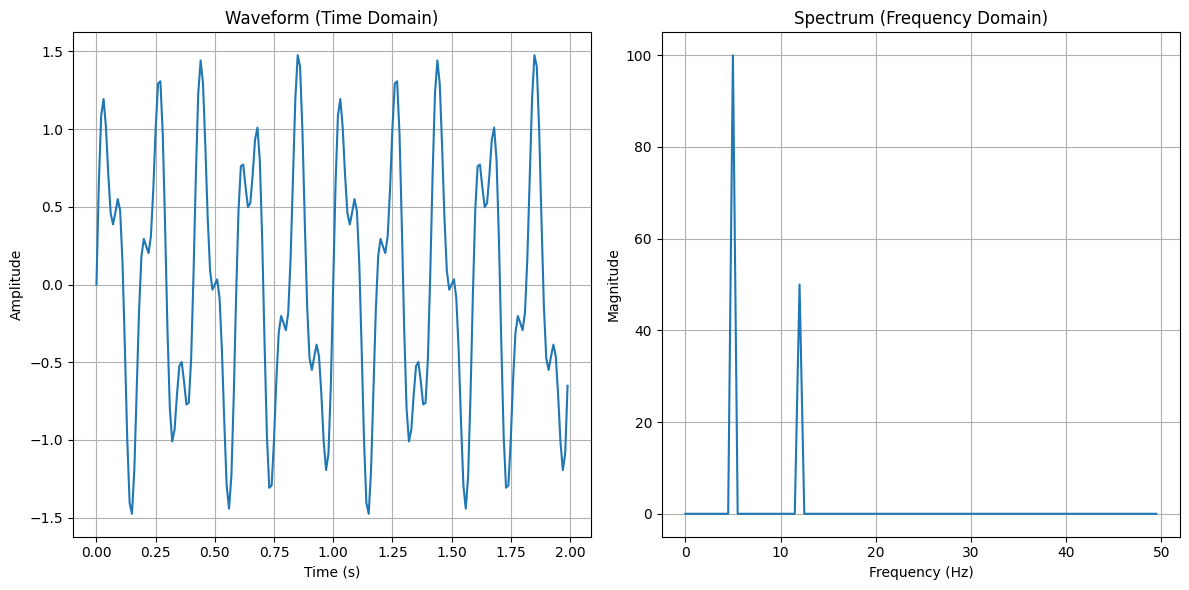

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Create a sample sound wave ---
sample_rate = 100  # samples per second
duration = 2      # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# A wave with a frequency of 5 Hz and another with 12 Hz
frequency1 = 5
frequency2 = 12
# Add the two waves together
amplitude1 = 1.0
amplitude2 = 0.5
signal = amplitude1 * np.sin(2 * np.pi * frequency1 * t) + amplitude2 * np.sin(2 * np.pi * frequency2 * t)


# --- 2. Apply the Fourier Transform ---
# The result of fft is an array of complex numbers
fft_result = np.fft.fft(signal)
# We take the absolute value (magnitude) to get the amplitude for each frequency
fft_magnitude = np.abs(fft_result)
# Create the frequency axis for the plot
frequencies = np.fft.fftfreq(len(signal), 1/sample_rate)


# --- 3. Plotting ---
plt.figure(figsize=(12, 6))

# Plot the original waveform
plt.subplot(1, 2, 1)
plt.title("Waveform (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(t, signal)
plt.grid(True)

# Plot the spectrum (the result of the FFT)
# We only plot the first half because the second half is a mirror image
n = len(frequencies)
plt.subplot(1, 2, 2)
plt.title("Spectrum (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.plot(frequencies[:n // 2], fft_magnitude[:n // 2])
plt.grid(True)

plt.tight_layout()
plt.show()



# 📘 Mini Booklet: Data Augmentation in Voice AI

---

## 1. Introduction

In **Voice AI**, models often require **large and diverse datasets**. But collecting voice data is expensive and time-consuming.
👉 **Data augmentation** is the process of creating *new training samples* by transforming existing audio files, while keeping their meaning the same.

For example:

* A spoken “Hello” can be stretched, shifted, or have noise added, yet still mean “Hello.”
* This helps the model become **robust** to variations like background noise, accents, and pitch.

---

## 2. Why Augmentation is Needed in Voice AI

* **Low-data scenarios** → Few recordings available.
* **Noise in real-world environments** → Models need to handle background disturbances.
* **Speaker variability** → Different accents, tones, and speeds.
* **Prevent overfitting** → Artificial diversity makes the model generalize better.

---

## 3. Common Audio Augmentation Techniques

1. **Time Stretching** → Speed up or slow down speech.
2. **Pitch Shifting** → Raise or lower voice pitch.
3. **Background Noise Injection** → Add street, café, or static noise.
4. **Time Shifting** → Shift audio slightly forward/backward in time.
5. **Volume Control** → Randomly increase or decrease loudness.
6. **SpecAugment** → Mask parts of the spectrogram (popular in deep learning).

---

## 4. Python Example

We’ll use **`librosa`** and **`numpy`** to apply basic augmentations.


In [ ]:
import librosa
import numpy as np
from IPython.display import Audio

# Load an example audio file
file = librosa.example('trumpet')  # replace with your own audio path if needed
y, sr = librosa.load(file, sr=None)

print("Original Audio Length:", len(y)/sr, "seconds")

# --- Augmentations ---

# 1. Time Stretching
y_fast = librosa.effects.time_stretch(y, rate=1.3)   # faster
y_slow = librosa.effects.time_stretch(y, rate=0.7)   # slower

# 2. Pitch Shifting (✅ use keyword args)
y_pitch_up = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=4)   # +4 semitones
y_pitch_down = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-4)

# 3. Add Noise
noise = np.random.normal(0, 0.01, y.shape)
y_noisy = y + noise

# --- Listen to Results ---
print("🎵 Original")
display(Audio(y, rate=sr))

print("⚡ Faster")
display(Audio(y_fast, rate=sr))

print("🐢 Slower")
display(Audio(y_slow, rate=sr))

print("⬆️ Pitch Up")
display(Audio(y_pitch_up, rate=sr))

print("⬇️ Pitch Down")
display(Audio(y_pitch_down, rate=sr))

print("🔊 With Noise")
display(Audio(y_noisy, rate=sr))


Original Audio Length: 5.333378684807256 seconds
🎵 Original


⚡ Faster


🐢 Slower


⬆️ Pitch Up


⬇️ Pitch Down


🔊 With Noise



## 5. Visualization Example

You can visualize the waveform or spectrogram before and after augmentation:


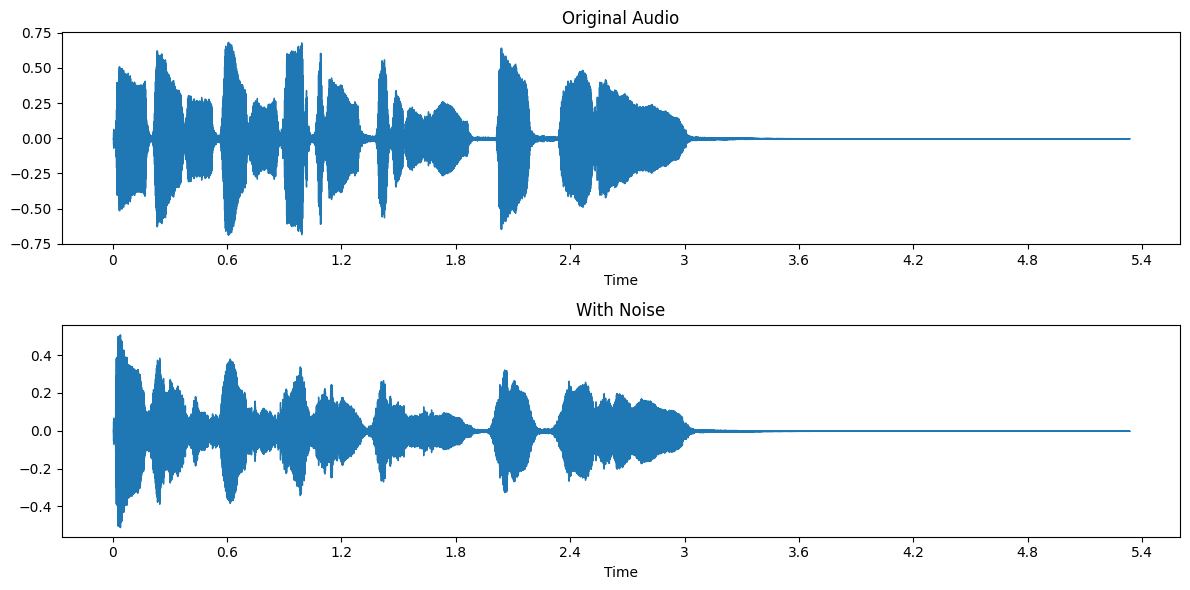

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Audio")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_pitch_up, sr=sr)
plt.title("With Noise")

plt.tight_layout()
plt.show()


## 6. Conclusion

Data augmentation in Voice AI is **critical** to:

* Make models robust to **real-world audio variability**
* Reduce **data collection costs**
* Improve **generalization and accuracy**

With just a few lines of Python, you can generate many new training samples from limited data.



# Whisper Model

Whisper is an end-to-end Transformer model that turns audio into text (or translations) by encoding audio features and then decoding them as tokens of text. It uses the same general encoder–decoder idea as many modern sequence-to-sequence models, but applied to log-Mel spectrograms instead of plain text.

## High-level pipeline

Whisper’s processing pipeline has three main steps: feature extraction, encoding, and autoregressive decoding. It is trained on millions of hours of audio–text pairs so that one single model can handle ASR, translation, language ID, and timestamps in a multitask fashion.

## Audio preprocessing

Input audio is resampled to 16 kHz, split into 30‑second chunks, and converted to an 80‑channel log‑Mel spectrogram using short-time windows (around 25 ms window, 10 ms stride).  These spectrograms are normalized to a roughly zero‑mean range like $$[-1, 1]$$ and used as the model’s “tokens” on the encoder side.

## Encoder architecture

The encoder is a stack of Transformer encoder blocks operating on the time–frequency spectrogram sequence. Whisper uses an initial convolutional “stem” followed by sinusoidal positional embeddings and standard multi-head self‑attention + feed‑forward blocks to produce a latent representation of the audio.

## Decoder and token generation

The decoder is a Transformer language model that takes text tokens plus cross‑attention to encoder outputs to generate the transcription. At inference, it generates tokens autoregressively (using greedy or beam search), so each new token is predicted from previous tokens and the encoded audio until an end token is reached.

## Multitask learning via special tokens

Whisper encodes tasks using special tokens at the beginning of the decoding sequence (for example tokens specifying language, “translate to English”, timestamps, etc.). By mixing these control tokens with normal text, the same model can do language ID, multilingual ASR, to‑English translation, and phrase‑level timestamping without separate task‑specific heads.

## Why it is robust

Whisper is trained on a very large, noisy, and diverse dataset (>5M hours) collected from the web with weak supervision, which improves robustness to accents, noise, and different domains compared with models trained on small clean corpora. This broad pretraining yields strong zero‑shot performance, although it can still hallucinate plausible text that is not in the audio, especially in underrepresented languages or domains.

## Model sizes and practical use

There are multiple Whisper checkpoints (tiny, base, small, medium, large) with parameter counts from tens of millions up to over a billion, trading speed for accuracy. In practice, a “processor” component handles resampling, spectrogram computation, and tokenization, then the model returns text (with optional timestamps) using the decoder’s generated token sequence.

If you want, the next step can be a more *mathy* view: dimensions of spectrograms, attention shapes, and how decoding is implemented (Greedy vs beam) so it connects to what you know from Transformers.


# What is Stem

In Whisper, “stem” means the small convolutional front-end that turns the raw log-Mel spectrogram into a sequence of embeddings before feeding it to the Transformer encoder. It is just a few conv layers (with stride > 1) that downsample in time and project the 80 Mel channels to the model dimension, acting like a feature extractor plus learnable “front” of the network.

## Why a stem is used

- It reduces the time resolution of the spectrogram so the Transformer sees fewer, more informative time steps, which makes training and inference cheaper
- It learns local time–frequency patterns (like short phonetic features) before self-attention, similar to how CNNs in vision models learn edges and textures before deeper layers.

If you want, the next step can be writing out the exact tensor shapes through the stem (e.g. from $$(T, 80)$$ spectrogram to $$(T', d_{\text{model}})$$) so it is crystal clear in linear algebra terms.
